# Install & Import packages
If we are in colab, we will install packages, else we import them only.


In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  !apt install tesseract-ocr
  !apt install tesseract-ocr-swe
  !pip install pytesseract
  !git clone https://github.com/fredrikwahlberg/5LN721.git
  %cd 5LN721

import matplotlib.pyplot as plt # Plotting, the line after this one is only for jupyter notebook
#%matplotlib inline
import cv2         # Image loading and manipulation
import numpy as np # Vector math

from levenshtein import wer, cer
import cv2                      # Computer Vision
import numpy as np              # Vector math
import pytesseract              # OCR
import os.path                  # File system stuff
import matplotlib.pyplot as plt # Plotting, the line after this one is only for jupyter notebook
%matplotlib inline

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  # Base package
  !apt install tesseract-ocr
  # Swedish language model
  !apt install tesseract-ocr-swe
  # Python bindings
  !pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr-swe is already the newest version (4.00~git24-0e00fe6-1.2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
fatal: destination path '5LN721' already exists and is not an empty directory.
/content/5LN721
Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr-swe is already the newest version (4.00~git24-0e00fe6-1.2).
0 upgraded, 0 newly installed, 0 to rem

# Description
In the text block below, you will find several tasks and questions in bold. These are what I want you to do and answer for the lab report. All answers are your way of arguing to me that you have understood the question/answer. You can hand in your report in traditional lab report format (pdf & latex) or (preferably) a jupyter notebook with your code and reflections as text blocks (you can use this one as a template assuming you remove my text and unnecessary code). 

#### Lab flow and grading criteria

You will analyse an OCR pipeline using given examples and some printed text of your choosing.

__Lab flow:__
* Download the code repo
* Experiment with the notebook
 * Do tasks and answer questions
* Create/find your own data (preferably in some other language than english)
 * Evaluate the OCR robustness on your data

__Pass:__ A quantitative analysis for how different types of image noise impacts the OCR quality, with and without a language model. For example code for noise, see the "image manipulation" notebook in the repo.

__Pass with distinction:__ In addition to the requirements for a passing grade, a qualitative analysis of OCR on some damaged and/or historical material you find or produce yourself.

In [ ]:
def jpeg_compression(image, quality=95):
    """
    Apply JPEG compression to an image in memory

    Parameters
    ----------
    image : array-like, shape (height, width)
        array representing the image
    quality : Quality level of the compression 0 - 100 (higher is better)

    Returns
    -------
    new_image : array-like, shape (height, width)
    """
    return cv2.imdecode(cv2.imencode(".jpg", image, [cv2.IMWRITE_JPEG_QUALITY, quality])[1], cv2.IMREAD_GRAYSCALE)

In [ ]:
def shrink_image(image, scale_percent=90):
    """
    Reduces the size of the image

    Parameters
    ----------
    image : array-like, shape (height, width)
        array representing the image
    scale_percent : size to scale down the image to 0 - 100

    Returns
    -------
    new_image : array-like, shape (height, width)
    """
    new_width = int(image.shape[1] * scale_percent / 100)
    new_height = int(image.shape[0] * scale_percent / 100)
    return cv2.resize(image, (new_width, new_height), interpolation = cv2.INTER_AREA)

def reverse_shrink(image, size):
  return cv2.resize(image, size, interpolation = cv2.INTER_AREA)


def shrink_reverse(image, scale):
  size = (image.shape[1], image.shape[0])
  image = shrink_image(image, scale)
  image = reverse_shrink(image, size)
  return image

In [ ]:
def distort(image, sigma):
    """Add Gaussian noise"""
    img_noise = image + np.random.normal(0, sigma, size=image.shape)
    img_noise[img_noise<0] = 0
    img_noise[img_noise>255] = 255
    return np.asarray(img_noise, dtype=np.uint8)

def blur(image, n):
    """Gaussian blur"""
    return cv2.GaussianBlur(image, (n, n), 0)

def binarize(image):
    """Separate foreground from background"""
    _, img_thresholded = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    img_thresholded[img_thresholded==0] = 140
    img_thresholded[img_thresholded==255] = 150
    return img_thresholded

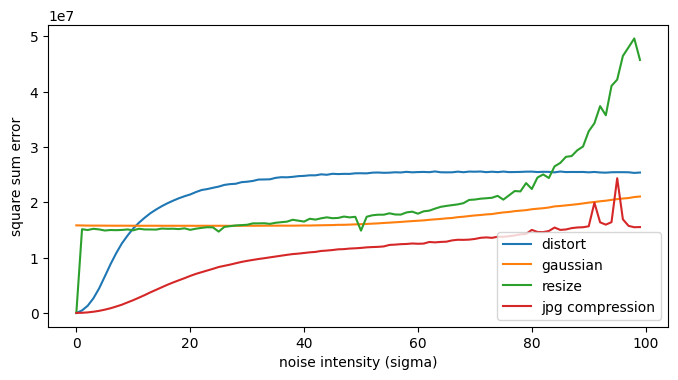



Below are different noise methods at their extremes


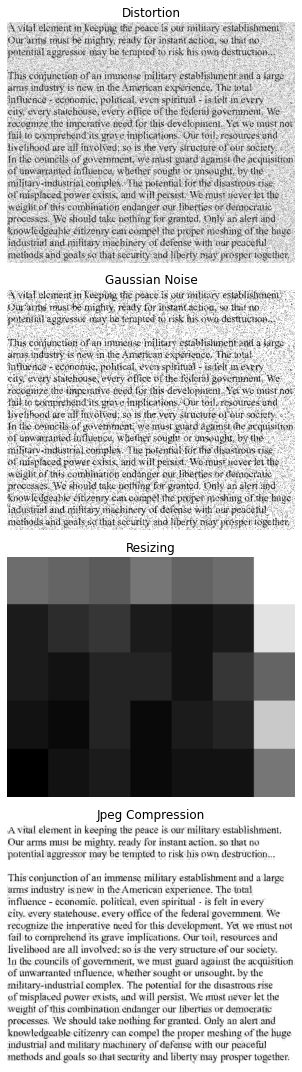

In [ ]:
eisenhower_image = cv2.imread("Eisenhower.png", cv2.IMREAD_GRAYSCALE)


sigmas = range(100)
distortsum = list()
gausum = list()
shrinksum = list()
compresssum = list()
img = eisenhower_image
for sigma in sigmas:
    distort_img = distort(eisenhower_image, sigma)
    distortsum.append(np.sum((img - distort_img)**2))
    gaus_img = binarize(blur(distort_img, 1))
    gausum.append(np.sum((img - gaus_img)**2))
    shrink_img = shrink_reverse(eisenhower_image, 100- sigma)
    shrinksum.append(np.sum((img - shrink_img)**2))
    compress_img = jpeg_compression(eisenhower_image, 100 - sigma)
    compresssum.append(np.sum((img - compress_img)**2))

plt.figure(figsize=(8, 4), dpi=100)
plt.plot(sigmas, distortsum, label="distort")
plt.plot(sigmas, gausum, label="gaussian")
plt.plot(sigmas, shrinksum, label="resize")
plt.plot(sigmas, compresssum, label="jpg compression")
plt.legend(loc='lower right')
plt.ylabel("square sum error")
plt.xlabel("noise intensity (sigma)")
plt.show()
print()
print()
print('Below are different noise methods at their extremes')
plt.figure(figsize=(30, 15))
plt.subplot(4, 1, 1)
plt.title('Distortion')
plt.imshow(distort_img, cmap='gray')
plt.axis('off')
plt.subplot(4, 1, 2)
plt.title('Gaussian Noise')
plt.imshow(gaus_img, cmap='gray')
plt.axis('off');
plt.subplot(4, 1, 3)
plt.title('Resizing')
plt.imshow(shrink_img, cmap='gray')
plt.axis('off');
plt.subplot(4, 1, 4)
plt.title('Jpeg Compression')
plt.imshow(compress_img, cmap='gray')
plt.axis('off');
plt.tight_layout()
plt.show()

# __Question1:__ 
Which types of noise do you think are most harmful? Comparer the noise types described in the "image manipulation" demo notebook.

Here I use different methods from this class to add noise to the image. They are gaussian noise, gaussian noise with distortion, resizeing and jpeg compression. To demonstrate their effects on image quality, I compute their square sum error with original images, and plot the errors through different degree of noise intensity. The noise intensity in the x-axis of the above graph has different meanings to different noise methods. For distortion and gaussian noise, its the distortion rate, for resizing, it's the shrinking percentage of the image, and for jpeg compression, 100 minus its value is the quality parameter for compression. 

The result images added with maximum noises through each methods are also shown above. We can clearly see that **resizing clearly destroys the image** (I resize it back to original size for error calculation). It has the highest error sum in the plot when noise intensity is high. But if we look at the region where noise intensity are below 50, distort methods add noises to the image relatively fast, the binarization of distort, which is represent as gaussian noise line in the graph, maintains the sum errors throughout the plot. Jpeg compression on the other hand, is designed for maintaining the important information of the image while discarding some part of its quality, has mild affect in increasing the noise.

Overall I would say **shrinking the image to smaller than 50%** of its original size is quite detrimental to the image quality. And **distortion** also introduce significant noise to the image. 

In [ ]:
with open("Eisenhower.txt", 'r') as file:
    original_text = file.read()

distort_text = pytesseract.image_to_string(distort_img, lang='swe')
gaus_text = pytesseract.image_to_string(gaus_img, lang='swe')
shrink_text = pytesseract.image_to_string(shrink_img, lang='swe')
compress_text = pytesseract.image_to_string(compress_img, lang='swe')

w_distort_eng = wer(original_text, distort_text)
w_gaus_eng = wer(original_text, gaus_text)
w_shrink__eng = wer(original_text, shrink_text)
w_compress_eng = wer(original_text, compress_text)

distort_text = pytesseract.image_to_string(distort_img)
gaus_text = pytesseract.image_to_string(gaus_img)
shrink_text = pytesseract.image_to_string(shrink_img)
compress_text = pytesseract.image_to_string(compress_img)

w_distort = wer(original_text, distort_text)
w_gaus = wer(original_text, gaus_text)
w_shrink = wer(original_text, shrink_text)
w_compress = wer(original_text, compress_text)


print('With English Language Model:')
print("Distortion word errors:", w_distort)
print("WER: %f" % w_distort[1])
print("Gaussian Noise word errors:", w_gaus)
print("WER: %f" % w_gaus[1])
print("Resizing word errors:", w_shrink)
print("WER: %f" % w_shrink[1])
print("Jpeg compression word errors:", w_compress)
print("WER: %f" % w_compress[1])
print()
print('With Swedish Language Model:')
print("Distortion word errors:", w_distort_eng)
print("WER: %f" % w_distort_eng[1])
print("Gaussian Noise word errors:", w_gaus_eng)
print("WER: %f" % w_gaus_eng[1])
print("Resizing word errors:", w_shrink__eng)
print("WER: %f" % w_shrink__eng[1])
print("Jpeg compression word errors:", w_compress_eng)
print("WER: %f" % w_compress_eng[1])



With English Language Model:
Distortion word errors: (197, 1.0)
WER: 1.000000
Gaussian Noise word errors: (197, 1.0)
WER: 1.000000
Resizing word errors: (197, 1.0)
WER: 1.000000
Jpeg compression word errors: (49, 0.24873096446700507)
WER: 0.248731

With Swedish Language Model:
Distortion word errors: (197, 1.0)
WER: 1.000000
Gaussian Noise word errors: (197, 1.0)
WER: 1.000000
Resizing word errors: (197, 1.0)
WER: 1.000000
Jpeg compression word errors: (59, 0.29949238578680204)
WER: 0.299492


Above result showcases the OCR performance on images made by different noise methods in their maximum noise level. Due to the default setting of pytesseract, the text extraction will uitilize English language model if not specified otherwise, meeaning the language model cannot be turned off. I use Swedish language model to serve as a paralell comparison.

The result shows that pytesseract OCR is very sensitive to noise as majority of the noise methods lead to 100% word error rate. Such a performance is still far from the reading ability of human, as images created by distortion or gaussian noise in max level are still readable to human. 

Overall only jpeg compression maintains the quality of the image for OCR. The effect of language model is as predicted, with Swedish language model having higher word error rate than English language model, since the text is written in English.

# **Question2**: 
What is the relation between the CER and WER. Does WER < CER always hold? Why (not)?


WER is defined as the sum of the number of word substitute, plus the number of word deleted and the number of word inserted to achieve the reference sentence (there are many combination of these three approaches for the algorithm to reconstruct reference sentence, the minimum sum will be chosen). Then the sum will be divided by the number of words in the reference sentence. CER is of similar calculation in the character level. 

WER is not always lower than CER, considering the reference sentence "Bird flies" and sentence for WER and CER examination "Dird fliez". The WER is 100% because both word in the sentence are wrong, but CER is 20% because out of all the 10 characters (space included), there are only two characters that are wrong. 

# __Pass with distinction:__ 
In addition to the requirements for a passing grade, a qualitative analysis of OCR on some damaged and/or historical material you find or produce yourself.

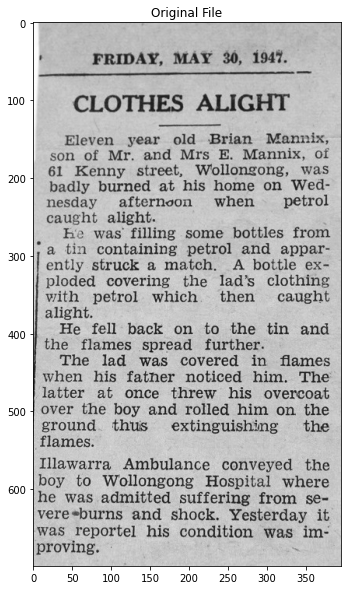

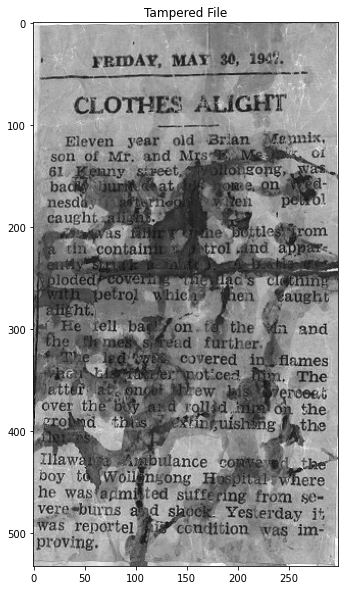

In [ ]:
image_with_text = cv2.imread("news.jpg", cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10, 10))
plt.title('Original File')
plt.imshow(image_with_text, cmap='gray')
plt.show()

image_with_text2 = cv2.imread("newsbad2.jpg", cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10, 10))
plt.title('Tampered File')
plt.imshow(image_with_text2, cmap='gray')
plt.show()

Above is a news story from an old Australian news paper. The first image is the original image. The second image is the tampered version that was crumpled up for extra wrinkles and added with soy sauce to mimic the damage and corruption of the document.

In [ ]:
with open("original.txt", 'r') as file:
    original_text = file.read()
print('Gold Version:')
print()
print(original_text)
print('-----------------')
print('Original Version:')
print()
extracted_text = pytesseract.image_to_string(image_with_text)
print(extracted_text)
print('----------------')
print('Tampered Version:')
print()
extracted_text2 = pytesseract.image_to_string(image_with_text2)
print(extracted_text2)

Gold Version:

FRIDAY, MAY 30, 1947.

CLOTHES ALIGHT

Eleven year old Brian Mannix,
son of Mr. and Mrs E. Mannix, of
61 Kenny street, Wollongong, was
badly burned at his home on Wed-
nesday afternoon when petrol
caught alight.

he was filling some bottles from
a tin containing petrol and appar-
ently struck a match. A bottle ex-
ploded covering the lad’s clothing
with petrol which. then caught
alight.

He fell back on to the tin and
the flames spread further.

The lad was covered in flames
when his father noticed him. The
latter at once threw his overcoat
over the boy and rolled him on the
ground. thus extinguishing the
flames.

Illawarra Ambulance conveyed the
boy to Wollongong Hospital where
he was admitted suffering from se-
vere burns and shock. Yesterday it
was reportel his condition was im-
proving.

-----------------
Original Version:

; FRIDAY, MAY 30, 1947.

CLOTHES ALIGHT

Eleven year old Brian Mannix,
son of Mr. and Mrs E. Mannix, of
61 Kenny street, Wollongong, was
badly bu

Above is the text from the news paper and texts extracted by pytesseract from original document and the tampered version. As we can see, pytesseract did a pretty good job in extracting the text from the original document, with only a few weird punctuation marks coming from the dirt on the original document.

The tampered version, on the other hand, completely ruins the OCR performanc, with only a tiny bits of words being captured. The result however is not surprising as we can see in Question 1 that pytesseract OCR is really sensitive to noises, giving poor results even when the noisy documents are still readable to human.


In [ ]:
print(original_text.split()[:20])
print(extracted_text.split()[:20])
print(extracted_text2.split()[:20])
we = wer(original_text, extracted_text)
we2 = wer(original_text, extracted_text2)
print("Word errors:", we)
print("WER: %f" % we[1])
print("Tampered version word errors:", we2)
print("Tampered version WER: %f" % we2[1])
print()
print()
print(list(original_text)[:20])
print(list(extracted_text)[:20])
print(list(extracted_text2)[:20])
ce = cer(original_text, extracted_text)
ce2 = cer(original_text, extracted_text2)
print("Character errors:", ce)
print("CER: %f" % ce[1])
print("Tampered version Character errors:", ce2)
print("Tampered version CER: %f" % ce2[1])

['FRIDAY,', 'MAY', '30,', '1947.', 'CLOTHES', 'ALIGHT', 'Eleven', 'year', 'old', 'Brian', 'Mannix,', 'son', 'of', 'Mr.', 'and', 'Mrs', 'E.', 'Mannix,', 'of', '61']
[';', 'FRIDAY,', 'MAY', '30,', '1947.', 'CLOTHES', 'ALIGHT', 'Eleven', 'year', 'old', 'Brian', 'Mannix,', 'son', 'of', 'Mr.', 'and', 'Mrs', 'E.', 'Mannix,', 'of']
['|', '_PRIDAY,', 'MAY', '$4,', '190),', 'CLOTHES', 'ALIGHT', 'from', 'se-', 'veresburns', '2', 'Yesterday', 'it', 'Was', 'reportel', 'pr', 'comitition', 'was', 'im:', 'proving,']
Word errors: (5, 0.036231884057971016)
WER: 0.036232
Tampered version word errors: (131, 0.9492753623188406)
Tampered version WER: 0.949275


['F', 'R', 'I', 'D', 'A', 'Y', ',', ' ', 'M', 'A', 'Y', ' ', '3', '0', ',', ' ', '1', '9', '4', '7']
[';', ' ', 'F', 'R', 'I', 'D', 'A', 'Y', ',', ' ', 'M', 'A', 'Y', ' ', '3', '0', ',', ' ', '1', '9']
['|', ' ', '_', 'P', 'R', 'I', 'D', 'A', 'Y', ',', ' ', 'M', 'A', 'Y', ' ', '$', '4', ',', ' ', '1']
Character errors: (12, 0.014814814814814815)
CER

Above is the character error rates and word error rates of the text extracted from original document and the tampered version. Here we can see a quantantative results of pytesseract's OCR performance. With orginal version WER 3.6% and CER 1.4% and tampered version WER 94.9% and CER 86.9%, we can clearly see the tampered version is almost unrecognizable to pytesseract.

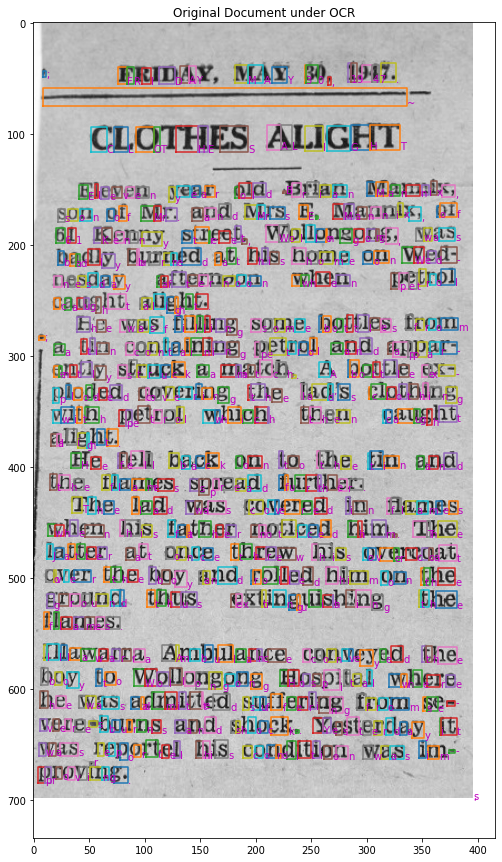

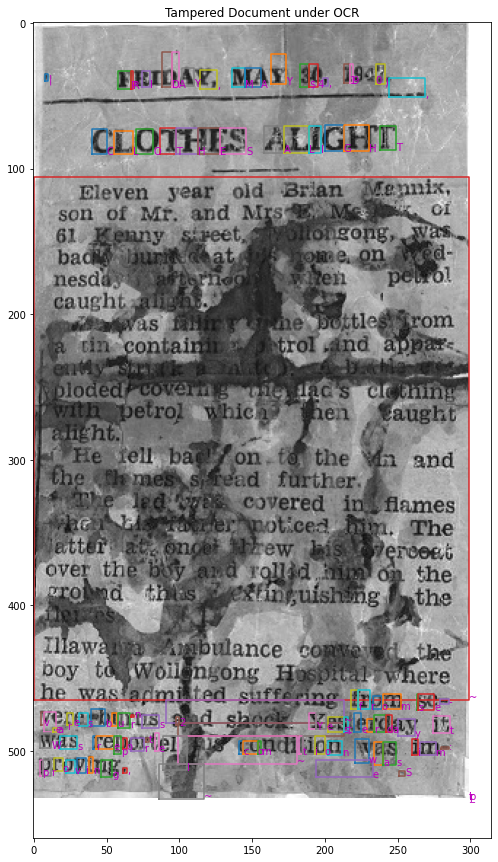

In [ ]:
img_cropped = image_with_text[:1020, :]
data = pytesseract.image_to_boxes(img_cropped)
plt.figure(figsize=(15, 15))
plt.imshow(img_cropped, cmap='gray')
for entry in data.split("\n"):
  if len(entry) > 0:
    char, y1, x1, y2, x2, _ = entry.split()
    y1 = int(y1)
    y2 = int(y2)
    x1 = img_cropped.shape[0]-int(x1)
    x2 = img_cropped.shape[0]-int(x2)
    plt.plot([y1, y2, y2, y1, y1], [x1, x1, x2, x2, x1]) # Plot the box
    plt.text(y2, x1, char, color='m') # Plot the OCRed character
plt.title('Original Document under OCR')
plt.show()

img_cropped = image_with_text2[:1020, :]
data = pytesseract.image_to_boxes(img_cropped)
plt.figure(figsize=(15, 15))
plt.imshow(img_cropped, cmap='gray')
for entry in data.split("\n"):
  if len(entry) > 0:
    char, y1, x1, y2, x2, _ = entry.split()
    y1 = int(y1)
    y2 = int(y2)
    x1 = img_cropped.shape[0]-int(x1)
    x2 = img_cropped.shape[0]-int(x2)
    plt.plot([y1, y2, y2, y1, y1], [x1, x1, x2, x2, x1]) # Plot the box
    plt.text(y2, x1, char, color='m') # Plot the OCRed character
plt.title('Tampered Document under OCR')
plt.show()

The above images showcase the text recognition detail of pytesseract for both versions of the document. The upper one is the original document, with every character and a bit of noise in the document considered as texts, the extracted text is close to the true texts. The lower one, on the other hand, reveals that pytesseract really has trouble finding target text in the area where background is slightly darker or the contrast between character and the background is less drastic.
